<a href="https://colab.research.google.com/github/vrathi101/NSDI-Inclusivity/blob/main/NSDIConference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and import necessary Python libraries for subsequent code (these libraries will be used throughout the Google Colabs.
1. Fuzzywuzzy is used for string matching (comparing strings which aren't identical but may have differences caused by typos, abbreviations, etc.). I used this when there weren't exact matches between the committee member dataframe and the researchers csv.
2. Levenshtein is used to measure the "distance" between strings which will be used for fuzzy comparing.
3. Beautifulsoup4 is used for webscraping. I used webscraping to extract the committee members for each year for SIGCOMM.
4. Gender-guesser is used to guess the gender of a person based on their first name. It have 6 possible outputs: 'male', 'mostly_male', 'female', 'mostly_female', 'andy', and 'unknown'. I used this for the names which had a fuzzy ratio of less than the fixed threshold when compared to every name in the researchers csv.

In [3]:
#install all packages
!pip install fuzzywuzzy
!pip install levenshtein
!pip install requests beautifulsoup4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 38.7 MB/s eta 0:00:00


Import all of the libraries we will be using.

In [4]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
proj_path = '/content/gdrive/MyDrive/Colab Notebooks/save_data/'

Mounted at /content/gdrive


Using webscraping to extract all the program committee and steering committee members and their institutions for NSDI from 2013-2023, inclusive, and then adding all the names/regions, categorized by year and committee type, into a dataframe.

In [ ]:
dfNSDI = pd.DataFrame(columns=['name', 'region', 'year', 'committee'])
committee = 'Program'

for year in range(2009, 2024):
  current_year = year % 100
  if(year>=2012):
    if(year > 2012):
      url = f"https://www.usenix.org/conference/nsdi{current_year}/call-for-papers"
    elif(year == 2012):
      url = f"https://www.usenix.org/conference/nsdi{current_year}/call-for-papers-0"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    program_committee_h3 = soup.find('h3', string='Program Committee')
    if program_committee_h3 is not None:
      name_divs = program_committee_h3.find_all_next('div')
      name_divs_filtered = []
      for div in name_divs:
        if div is not None:
          if div.find_previous_sibling('h3') == program_committee_h3:
            name_divs_filtered.append(div)
      for div in name_divs_filtered:
        name_div = div.find('div', class_='field-content').text.strip()
        if name_div is not None:
          name_text = name_div.strip()
          if ',' in name_text:
            name = name_text.split(',')[0].strip()
          region_tag = div.find('em')
          if region_tag is not None:
            region = region_tag.text.strip()
            name = name.replace(region_tag.text, '')
          else:
            region = None
          df = pd.DataFrame({'name': [name], 'region': [region], 'year': year, 'committee': committee})
          dfNSDI = pd.concat([dfNSDI, df], ignore_index=True)
  elif year < 2012:
    if(year in [2010, 2011]):
      url = f"https://www.usenix.org/legacy/events/nsdi{current_year}/cfp/"
    elif(year==2009):
      url = f"https://www.usenix.org/legacy/nsdi09/cfp/"
    response = requests.get(url)
    html_content = response.text
    soup = BeautifulSoup(html_content, "html.parser")

    p_elements = soup.find_all("p")
    program_committee_names = []
    program_committee_regions = []

    for p_element in p_elements:
        if p_element.find("b", string="Program Committee"):
            br_elements = p_element.find_all("br")
            names = [br_element.next_sibling.strip().strip(', ') for br_element in br_elements]
            regions = [br_element.find_next("i").text.strip() for br_element in br_elements]


    df = pd.DataFrame({'name': names, 'region': regions, 'year': year, 'committee': committee})
    dfNSDI = pd.concat([dfNSDI, df], ignore_index=True)

dfNSDI = dfNSDI.reset_index(drop=True)
dfNSDI.head(10)

,name,region,year,committee
0,Miguel Castro,Microsoft Research,2009,Program
1,Jeff Dean,"Google, Inc.",2009,Program
2,Nick Feamster,Georgia Institute of Technology,2009,Program
3,Michael J. Freedman,Princeton University,2009,Program
4,Steven D. Gribble,University of Washington,2009,Program
5,Krishna Gummadi,Max Planck Institute for Software Systems,2009,Program
6,Steven Hand,University of Cambridge,2009,Program
7,Farnam Jahanian,University of Michigan,2009,Program
8,Dina Katabi,Massachusetts Institute of Technology,2009,Program
9,Arvind Krishnamurthy,University of Washington,2009,Program


In [ ]:
committee = 'Steering'

for year in range(2009, 2024):
  current_year = year % 100
  if(year>=2012):
    if(year > 2012):
      url = f"https://www.usenix.org/conference/nsdi{current_year}/call-for-papers"
    elif(year == 2012):
      url = f"https://www.usenix.org/conference/nsdi{current_year}/call-for-papers-0"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    program_committee_h3 = soup.find('h3', string='Steering Committee')
    if program_committee_h3 is not None:
      name_divs = program_committee_h3.find_all_next('div')
      name_divs_filtered = []
      for div in name_divs:
        if div is not None:
          if div.find_previous_sibling('h3') == program_committee_h3:
            name_divs_filtered.append(div)
      for div in name_divs_filtered:
        name_div = div.find('div', class_='field-content').text.strip()
        if name_div is not None:
          name_text = name_div.strip()
          if ',' in name_text:
            name = name_text.split(',')[0].strip()
          region_tag = div.find('em')
          if region_tag is not None:
            region = region_tag.text.strip()
            name = name.replace(region_tag.text, '')
          else:
            region = None
          df = pd.DataFrame({'name': [name], 'region': [region], 'year': year, 'committee': committee})
          dfNSDI = pd.concat([dfNSDI, df], ignore_index=True)
  elif year < 2012:
    if(year in [2010, 2011]):
      url = f"https://www.usenix.org/legacy/events/nsdi{current_year}/cfp/"
    elif(year==2009):
      url = f"https://www.usenix.org/legacy/nsdi09/cfp/"
    response = requests.get(url)
    html_content = response.text
    soup = BeautifulSoup(html_content, "html.parser")

    p_elements = soup.find_all("p")
    program_committee_names = []
    program_committee_regions = []

    for p_element in p_elements:
        if p_element.find("b", string="Steering Committee"):
            br_elements = p_element.find_all("br")
            names = [br_element.next_sibling.strip().strip(', ') for br_element in br_elements]
            regions = [br_element.find_next("i").text.strip() for br_element in br_elements]

    df = pd.DataFrame({'name': names, 'region': regions, 'year': year, 'committee': committee})
    dfNSDI = pd.concat([dfNSDI, df], ignore_index=True)

dfNSDI = dfNSDI.reset_index(drop=True)
# Print the final DataFrame
print(dfNSDI.head(5))
print(len(dfNSDI))
print(dfNSDI.groupby(['year', 'committee'])['year', 'committee'].count())

                  name                           region  year committee
0        Miguel Castro               Microsoft Research  2009   Program
1            Jeff Dean                     Google, Inc.  2009   Program
2        Nick Feamster  Georgia Institute of Technology  2009   Program
3  Michael J. Freedman             Princeton University  2009   Program
4    Steven D. Gribble         University of Washington  2009   Program
810
                year  committee
year committee                 
2009 Program      23         23
     Steering      7          7
2010 Program      23         23
     Steering      7          7
2011 Program      24         24
     Steering      7          7
2012 Program      25         25
     Steering      6          6
2013 Program      30         30
     Steering      7          7
2014 Program      32         32
     Steering      7          7
2015 Program      43         43
     Steering      7          7
2016 Program      40         40
     Steering      7

<ipython-input-5-6e64bb92c6aa>:61: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(dfNSDI.groupby(['year', 'committee'])['year', 'committee'].count())


Polishing the dataframe to make matching easier.

In [ ]:
dfNSDI['name']=dfNSDI['name'].str.replace('\xa0', ' ')

In [ ]:
updates1 = [
    (607, 'Rebecca Isaacs', 'Amazon'),
    (715, 'Mike Schroeder', 'Microsoft Research'),
    (170, 'Mark Handley', 'University College London')
]
for index, new_name, new_region in updates1:
  dfNSDI.at[index, 'name'] = new_name
  dfNSDI.at[index, 'region'] = new_region

dfNSDI = dfNSDI.reset_index(drop=True)
updates2 = [
    (16, 'Rama Ramasubramanian'),
    (3, 'Mike Freedman'),
    (29, 'Mike Freedman'),
    (76, 'Mike Freedman'),
    (102, 'Mike Freedman'),
    (19, 'Geoff Voelker'),
    (90, 'Geoff Voelker'),
    (120, 'Lakshminarayanan Subramanian'),
    (192, 'Lakshminarayanan Subramanian'),
    (175, 'Kimberly Keeton'),
    (223, 'Kate Ching-Ju Lin'),
    (241, 'Thomas E. Anderson'),
    (262, 'Jay Lorch'),
    (265, 'David Maltz'),
    (321, 'Timothy Wood 0001'),
    (410, 'Jitendra Padhye'),
    (450, 'Matthew Caesar 0001'),
    (473,'Changhoon Kim'),
    (638,'Jennifer Rexford'),
    (648, 'Dimitrios Skarlatos 0002'),
]
for index, new_name in updates2:
  dfNSDI.at[index, 'name'] = new_name

In [ ]:
# Grouping the dataframe by year and committee
grouped = dfNSDI.groupby(['year', 'committee'])

# Checking for duplicate names within each group
duplicates = grouped.apply(lambda x: x[x['name'].duplicated(keep=False)])

if duplicates.empty:
    print("No duplicates exist.")
else:
    print("Duplicate names found:")
    for index, duplicate in duplicates.iterrows():
        print(f"Indexes: {index}, Name: {duplicate['name']}")

No duplicates exist.


Writing the current dataframe to Google Drive as a CSV to read as we go on.

In [ ]:
dfNSDI.to_csv("/content/gdrive/My Drive/Colab Notebooks/save_data/NSDINames.csv", sep=',', index=False, encoding='utf-8')

NameError: ignored

Reading both the NSDI dataframe and the manually-curated researcher data dataframe and making some adjustments.

In [13]:
dfNSDI = pd.read_csv(proj_path + 'NSDINames.csv')
dfResearchers = pd.read_csv(proj_path + 'researcher.csv')
# Specify the columns to extract from the 'researchers' DataFrame
columns_to_extract =['Name','Female or NB', 'Region', 'Approximate Doctoral Degree Graduation Year']
# Create a new DataFrame 'dfResearcher' with the selected columns
dfResearcher = dfResearchers[columns_to_extract]
dfResearcher.rename(columns={'Female or NB': 'Gender'}, inplace=True)
dfResearcher['Gender'] = dfResearcher['Gender'].replace({float('Nan'): 'Male', 1.0: 'Female'})
dfResearcher.rename(columns={'Approximate Doctoral Degree Graduation Year': 'ApproximateDoctoralGradYear'}, inplace=True)
dfResearcher['Region'].fillna('NorAm', inplace=True)
dfResearcher.drop_duplicates(subset = 'Name', inplace=True)
for column in dfResearcher.columns:
  dfResearcher[column] = dfResearcher[column].str.strip()
print(dfResearcher.head())
print(len(dfResearcher))

              Name  Gender Region ApproximateDoctoralGradYear
0  Sergey Gorinsky    Male     EU                        2003
1   Hitesh Ballani    Male     EU                        2009
2     Haya Shulman  Female     EU                        2014
3  Rüdiger Birkner    Male     EU                        2018
4     Klaus Wehrle    Male     EU                        2002
1025


<ipython-input-13-67e6c3ce5c37>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfResearcher.rename(columns={'Female or NB': 'Gender'}, inplace=True)
<ipython-input-13-67e6c3ce5c37>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfResearcher['Gender'] = dfResearcher['Gender'].replace({float('Nan'): 'Male', 1.0: 'Female'})
<ipython-input-13-67e6c3ce5c37>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

Adding columns to dfNSDI (original) dataframe by comparing it with dfResearcher dataframe based on the full name of a committee member and a fuzzy match. Another column is used for the gender-guesser library which guesses the gender for every NSDI member in dfNSDI.
Additionally, for all the committee members whose continent of location could not be determined, it will check if the dfResearcher has these names with their regions and add it in accordingly.

In [14]:
#add a DirectMatch column which puts in gender if found in dfResearcher based on code
dfNSDI['DirectMatch'] = ''
for index, row in dfNSDI.iterrows():
  chkName=row['name'].strip()
  gender=''
  if (chkName in dfResearcher['Name'].values):
    first_location  = dfResearcher.loc[dfResearcher['Name'] == chkName].index[0]
    gender = dfResearcher.loc[first_location, 'Gender']
    dfNSDI.at[index, 'DirectMatch'] = gender
print(dfNSDI.groupby(['DirectMatch'])['DirectMatch'].count())

#add a FuzzyMatch column which puts in gender if found in dfResearcher based on code
dfNSDI['FuzzyMatch'] = ''
dfNSDI['Continent'] = ''
dfNSDI['ApproximateDoctoralGradYear'] = ''
for idx, row in dfNSDI.iterrows():
    name_updated = row['name']
    #region_updated = row['region']
    continent = row['Continent']
    gradYear = row['ApproximateDoctoralGradYear']
    best_match = None
    best_score = 0
    researcher_row = None
    for _, research_row in dfResearcher.iterrows():
        name_research = research_row['Name']
        score = fuzz.token_set_ratio(name_updated, name_research)
        if score > best_score and score > 90:
            best_match = research_row['Gender']
            best_score = score
            researcher_row = research_row
        if score == 100:  # If perfect match, break the loop
            break
    dfNSDI.loc[idx, 'FuzzyMatch'] = best_match
    if continent.strip()=='' and researcher_row is not None:
      dfNSDI.loc[idx, 'Continent'] = researcher_row['Region']
    if gradYear.strip()=='' and researcher_row is not None:
      dfNSDI.loc[idx, 'ApproximateDoctoralGradYear'] = researcher_row['ApproximateDoctoralGradYear']
print(dfNSDI.groupby(['FuzzyMatch'])['FuzzyMatch'].count())

DirectMatch
           88
Female    151
Male      571
Name: DirectMatch, dtype: int64
FuzzyMatch
Female    177
Male      633
Name: FuzzyMatch, dtype: int64


Wriitng the current dataframe to a CSV and reading it again as we go on.

In [15]:
dfNSDI.to_csv("/content/gdrive/My Drive/Colab Notebooks/save_data/NSDINamesAdjusted.csv", sep=',', index=False, encoding='utf-8')

In [16]:
dfNSDI = pd.read_csv(proj_path + 'NSDINamesAdjusted.csv')

Changing the names of the values in the 'Continent' column to their full names. This will be used in the graphs at the end.

In [17]:
continent_mapping = {
    'NorAm': 'North America',
    'AS': 'Asia',
    'Asia': 'Asia',
    'OC': 'Australia',
    'Australia': 'Australia',
    'SA': 'South America',
    'Africa': 'Africa',
    'AF': 'Africa',
    'EU': 'Europe'
}
dfNSDI['Continent'] = dfNSDI['Continent'].replace(continent_mapping)

Filling in the dataframe Gender column based on the columns DirectMatch, FuzzyMatching, and GenderGuesser which receive priority in the order listed.

In [18]:
#create an empty Gender column
dfNSDI['Gender']=''

#GenderFullNameMatch checked first
dfNSDI['Gender'] = dfNSDI['Gender'].replace('', np.nan)
dfNSDI['Gender'] = dfNSDI['Gender'].fillna(dfNSDI['DirectMatch'])

#FuzzyMatching checked second
dfNSDI['Gender'] = dfNSDI['Gender'].fillna(dfNSDI['FuzzyMatch'])

Determining the method used to find gender based on which columns had empty values vs. non-empty values.

In [19]:
dfNSDI['Source'] = ''
for index, row in dfNSDI.iterrows():
  # if column A is nonempty, fill in Source (method) with column A method name
  if not pd.isnull(row['DirectMatch']):
    dfNSDI.loc[index, 'Source'] = 'FullNameMatch'
  # if column A is empty and column B is nonempty, fill in Source with column B method name
  elif pd.isnull(row['DirectMatch']) and pd.notna(row['FuzzyMatch']):
    dfNSDI.loc[index, 'Source'] = 'FuzzyMatch'
dfNSDI.head(10)

,name,region,year,committee,DirectMatch,FuzzyMatch,Continent,ApproximateDoctoralGradYear,Gender,Source
0,Miguel Castro,Microsoft Research,2009,Program,Male,Male,North America,2001,Male,FullNameMatch
1,Jeff Dean,"Google, Inc.",2009,Program,Male,Male,North America,1996,Male,FullNameMatch
2,Nick Feamster,Georgia Institute of Technology,2009,Program,Male,Male,North America,2005,Male,FullNameMatch
3,Mike Freedman,Princeton University,2009,Program,Male,Male,North America,2007,Male,FullNameMatch
4,Steven D. Gribble,University of Washington,2009,Program,Male,Male,North America,2000,Male,FullNameMatch
5,Krishna Gummadi,Max Planck Institute for Software Systems,2009,Program,NaN,Male,Europe,2005,Male,FuzzyMatch
6,Steven Hand,University of Cambridge,2009,Program,Male,Male,Europe,1998,Male,FullNameMatch
7,Farnam Jahanian,University of Michigan,2009,Program,Male,Male,North America,1989,Male,FullNameMatch
8,Dina Katabi,Massachusetts Institute of Technology,2009,Program,Female,Female,North America,2003,Female,FullNameMatch
9,Arvind Krishnamurthy,University of Washington,2009,Program,Male,Male,North America,1998,Male,FullNameMatch


Again writing the current (final) dataframe to another CSV.

In [20]:
dfNSDI.to_csv("/content/gdrive/My Drive/Colab Notebooks/save_data/NSDINamesFinal.csv", sep=',', index=False, encoding='utf-8')

Making graphs showing the changes of gender distribution (as a percentage and as a count) for each of the two committee types over the entire time span.

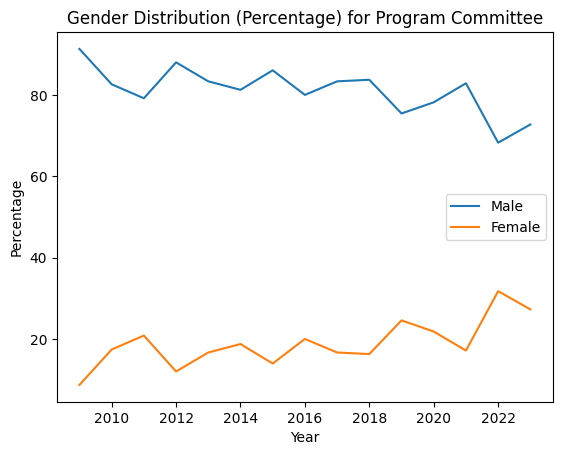

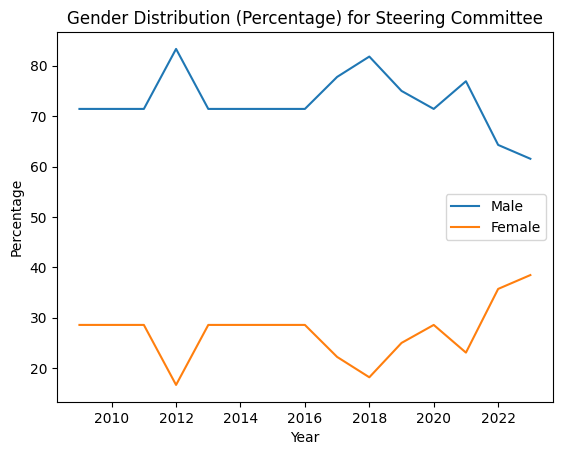

In [ ]:
# Get unique committee and year values from the DataFrame
committees = dfNSDI['committee'].unique()
years = dfNSDI['year'].unique()

# Get unique continent values from the "Continent" column
genders = dfNSDI['Gender'].unique()

# Create separate line graphs for each committee
for committee in committees:
    # Create a figure and axis for the current committee
    fig, ax = plt.subplots()

    # Loop through each continent
    for gender in genders:
        # Create an empty list to store the percentages for each year
        percentages = []

        # Loop through each year
        for year in years:
            # Filter the DataFrame for the current committee, continent, and year
            df_filtered = dfNSDI[(dfNSDI['committee'] == committee) & (dfNSDI['Gender'] == gender) & (dfNSDI['year'] == year)]

            # Get the count of members for the current continent and year
            count = len(df_filtered)

            # Calculate the percentage by dividing the count by the total count for the committee and year
            total_count = len(dfNSDI[(dfNSDI['committee'] == committee) & (dfNSDI['year'] == year)])
            percentage = (count / total_count) * 100

            # Append the percentage to the list
            percentages.append(percentage)

        # Plot the percentages as a line graph for the current continent
        ax.plot(years, percentages, label=gender)

    # Configure the plot
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Gender Distribution (Percentage) for {committee} Committee')
    ax.legend()

    # Display the plot
    plt.show()

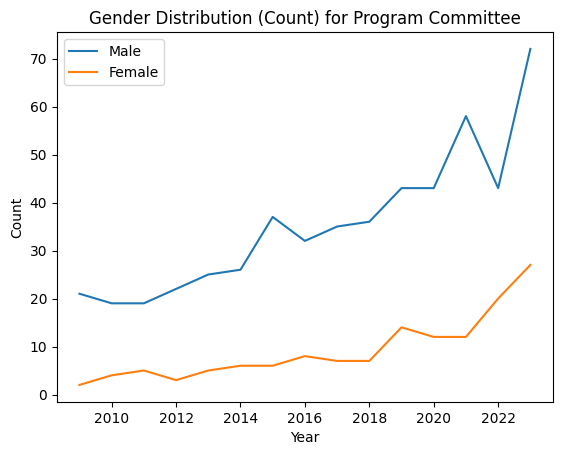

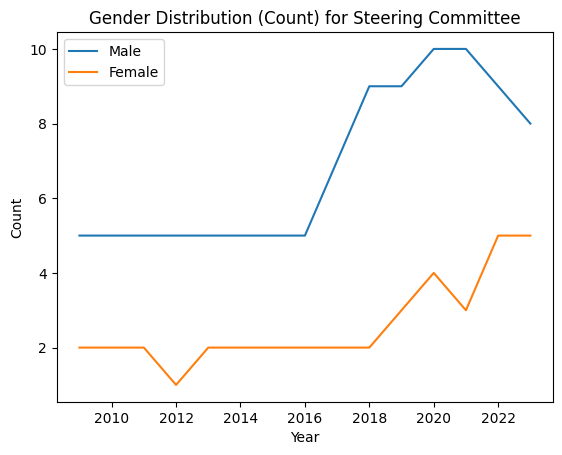

In [ ]:
# Get unique committee and year values from the DataFrame
committees = dfNSDI['committee'].unique()
years = dfNSDI['year'].unique()

# Get unique continent values from the "Continent" column
genders = dfNSDI['Gender'].unique()

# Create separate line graphs for each committee
for committee in committees:
    # Create a figure and axis for the current committee
    fig, ax = plt.subplots()

    # Loop through each continent
    for gender in genders:
        # Create an empty list to store the counts for each year
        counts = []

        # Loop through each year
        for year in years:
            # Filter the DataFrame for the current committee, continent, and year
            df_filtered = dfNSDI[(dfNSDI['committee'] == committee) & (dfNSDI['Gender'] == gender) & (dfNSDI['year'] == year)]

            # Get the count of members for the current continent and year
            count = len(df_filtered)

            # Append the count to the list
            counts.append(count)

        # Plot the counts as a line graph for the current continent
        ax.plot(years, counts, label=gender)

    # Configure the plot
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    ax.set_title(f'Gender Distribution (Count) for {committee} Committee')
    ax.legend()

    # Display the plot
    plt.show()

Making graphs showing the changes of geographic distribution (as a percentage and as a count) for each of the two committee types over the entire time span.

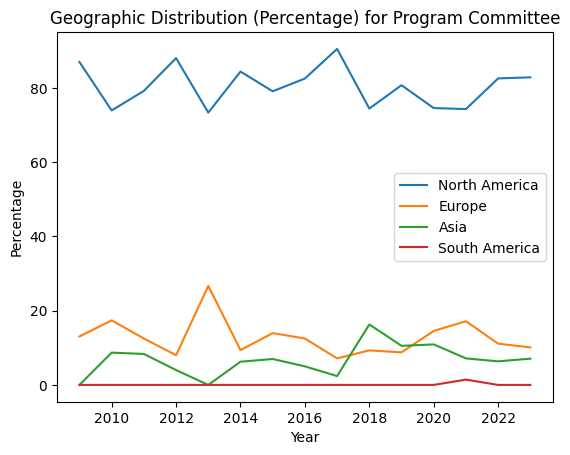

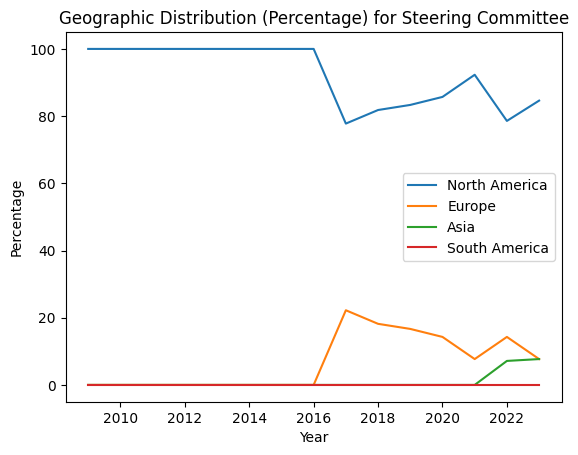

In [ ]:
# Get unique committee and year values from the DataFrame
committees = dfNSDI['committee'].unique()
years = dfNSDI['year'].unique()

# Get unique continent values from the "Continent" column
continents = dfNSDI['Continent'].unique()

# Create separate line graphs for each committee
for committee in committees:
    # Create a figure and axis for the current committee
    fig, ax = plt.subplots()

    # Loop through each continent
    for continent in continents:
        # Create an empty list to store the percentages for each year
        percentages = []

        # Loop through each year
        for year in years:
            # Filter the DataFrame for the current committee, continent, and year
            df_filtered = dfNSDI[(dfNSDI['committee'] == committee) & (dfNSDI['Continent'] == continent) & (dfNSDI['year'] == year)]

            # Get the count of members for the current continent and year
            count = len(df_filtered)

            # Calculate the percentage by dividing the count by the total count for the committee and year
            total_count = len(dfNSDI[(dfNSDI['committee'] == committee) & (dfNSDI['year'] == year)])
            percentage = (count / total_count) * 100

            # Append the percentage to the list
            percentages.append(percentage)

        # Plot the percentages as a line graph for the current continent
        ax.plot(years, percentages, label=continent)

    # Configure the plot
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Geographic Distribution (Percentage) for {committee} Committee')
    ax.legend()

    # Display the plot
    plt.show()

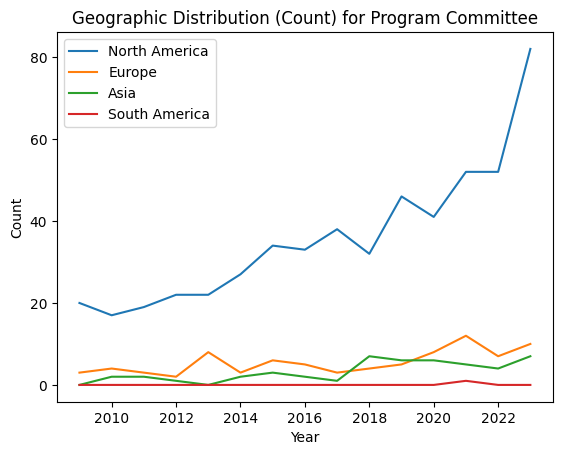

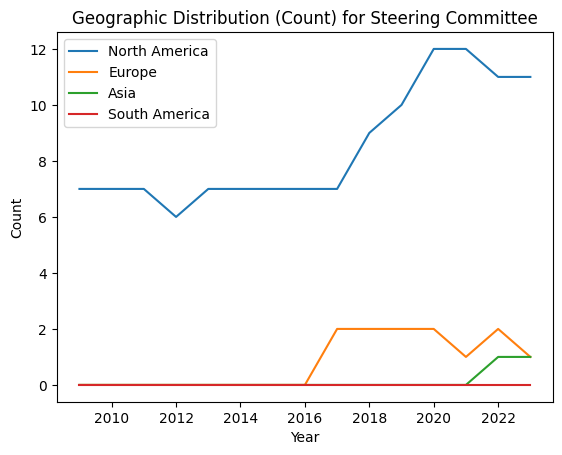

In [ ]:
# Get unique committee and year values from the DataFrame
committees = dfNSDI['committee'].unique()
years = dfNSDI['year'].unique()

# Get unique continent values from the "Continent" column
continents = dfNSDI['Continent'].unique()

# Create separate line graphs for each committee
for committee in committees:
    # Create a figure and axis for the current committee
    fig, ax = plt.subplots()

    # Loop through each continent
    for continent in continents:
        # Create an empty list to store the counts for each year
        counts = []

        # Loop through each year
        for year in years:
            # Filter the DataFrame for the current committee, continent, and year
            df_filtered = dfNSDI[(dfNSDI['committee'] == committee) & (dfNSDI['Continent'] == continent) & (dfNSDI['year'] == year)]

            # Get the count of members for the current continent and year
            count = len(df_filtered)

            # Append the count to the list
            counts.append(count)

        # Plot the counts as a line graph for the current continent
        ax.plot(years, counts, label=continent)

    # Configure the plot
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    ax.set_title(f'Geographic Distribution (Count) for {committee} Committee')
    ax.legend()

    # Display the plot
    plt.show()

Making graphs showing the (1) average doctoral degree graduation year and (2) the difference between the doctoral degree graduation year and the year of the conference, for each of the two committee types over the 15-year span. We exclude people whose doctoral degree information was not found.

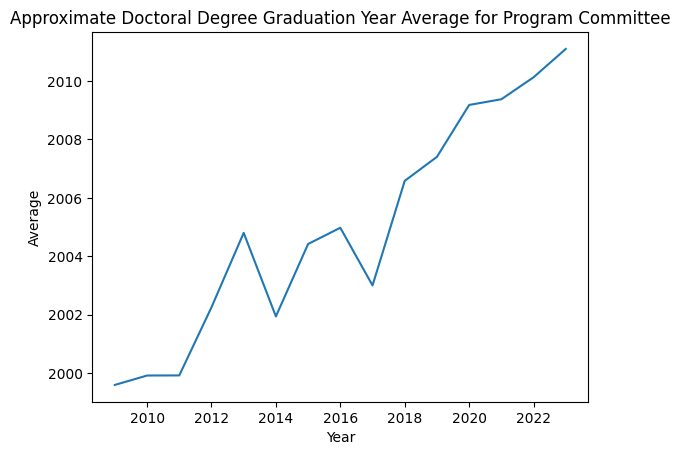

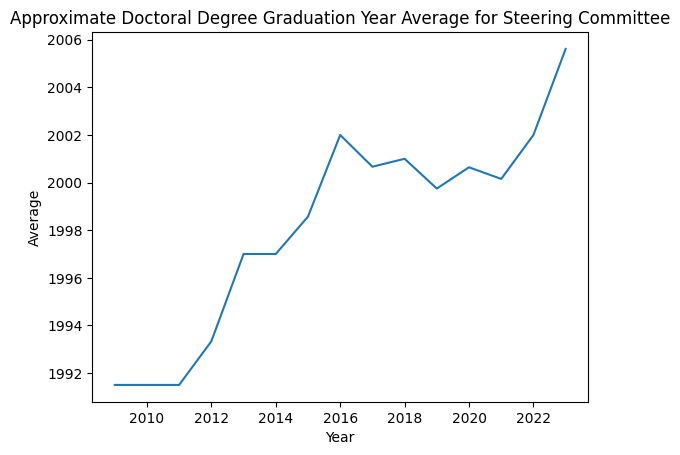

In [24]:
# Get unique committee and year values from the DataFrame
committees = dfNSDI['committee'].unique()
years = dfNSDI['year'].unique()

for committee in committees:
    # Create a new figure and axes for each committee
    fig, ax = plt.subplots()
    # Initialize an empty list to store the average values
    averages = []

    for year in years:
        # Initialize the sum of graduation years to 0 for each committee and year
        age_sum = 0

        # Filter the dataframe for the specific committee and year
        committee_year_df = dfNSDI[(dfNSDI['committee'] == committee) & (dfNSDI['year'] == year)]
        committee_year_df = committee_year_df[~committee_year_df['ApproximateDoctoralGradYear'].isin(['None', '?', 'Phd'])]
        committee_year_df['ApproximateDoctoralGradYear'] = pd.to_numeric(committee_year_df['ApproximateDoctoralGradYear'], errors='coerce')
        # Count the number of records for the specific committee and year
        total_count = len(committee_year_df)

        if total_count > 0:
            # Calculate the sum of 'ApproximateDoctoralGradYear' for the specific committee and year
            age_sum = committee_year_df['ApproximateDoctoralGradYear'].sum()

            # Calculate the average graduation year for the specific committee and year
            average = age_sum / total_count

        # Append the average to the list of averages
        averages.append(average)

    # Plot the averages as a line graph for the current year
    ax.plot(years, averages)

    # Configure the plot
    ax.set_xlabel('Year')
    ax.set_ylabel('Average')
    ax.set_title(f'Approximate Doctoral Degree Graduation Year Average for {committee} Committee')

    # Display the plot
    plt.show()


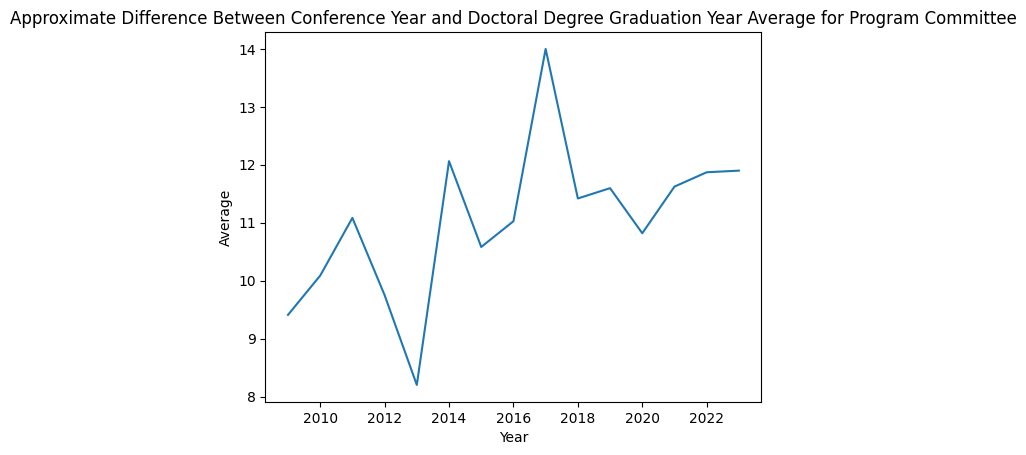

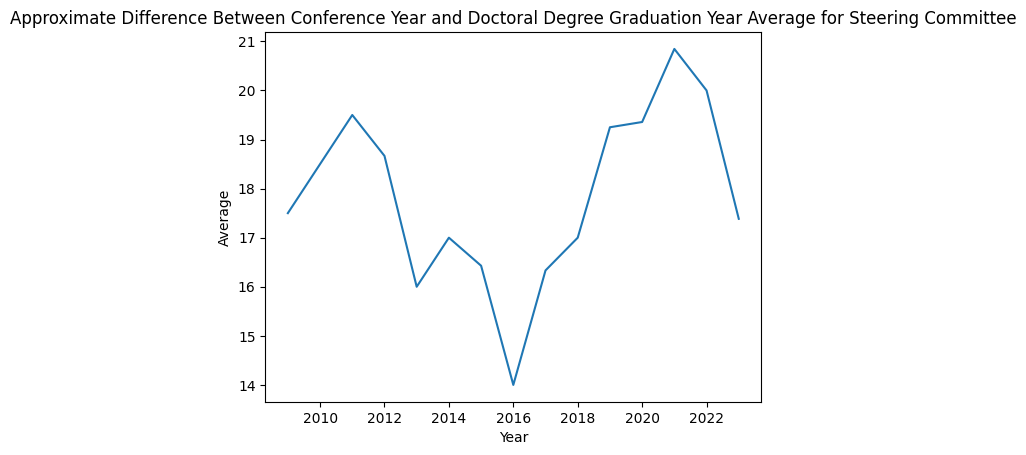

In [27]:
# Get unique committee and year values from the DataFrame
committees = dfNSDI['committee'].unique()
years = dfNSDI['year'].unique()

for committee in committees:
    # Create a new figure and axes for each committee
    fig, ax = plt.subplots()
    # Initialize an empty list to store the average values
    differences = []

    for year in years:
        # Initialize the sum of graduation years to 0 for each committee and year
        age_sum = 0

        # Filter the dataframe for the specific committee and year
        committee_year_df = dfNSDI[(dfNSDI['committee'] == committee) & (dfNSDI['year'] == year)]
        committee_year_df = committee_year_df[~committee_year_df['ApproximateDoctoralGradYear'].isin(['None', '?', 'Phd'])]
        committee_year_df['ApproximateDoctoralGradYear'] = pd.to_numeric(committee_year_df['ApproximateDoctoralGradYear'], errors='coerce')
        # Count the number of records for the specific committee and year
        total_count = len(committee_year_df)

        if total_count > 0:
            # Calculate the sum of 'ApproximateDoctoralGradYear' for the specific committee and year
            age_sum = committee_year_df['ApproximateDoctoralGradYear'].sum()

            # Calculate the average graduation year for the specific committee and year
            average = age_sum / total_count
            difference = abs(year - average)
        # Append the average to the list of averages
        differences.append(difference)

    # Plot the averages as a line graph for the current year
    ax.plot(years, differences)

    # Configure the plot
    ax.set_xlabel('Year')
    ax.set_ylabel('Average')
    ax.set_title(f'Approximate Difference Between Conference Year and Doctoral Degree Graduation Year Average for {committee} Committee')

    # Display the plot
    plt.show()
